In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
from src.model.city import City
from src.simulation.simulation import Simulation, time_of_number_of_days
from src.data_processing import bikes_scoring, station_changes, processing_constants

In [3]:
city = City.from_numbers(100, 10).assign_bikes_randomly()
time = time_of_number_of_days(7)
simulaiton = Simulation()

simulaiton.simulate(city, time)

simulating: 100%|████████████████████████| 2016/2016 [00:00<00:00, 2687.99it/s]


In [4]:
broken_bikes = simulaiton.get_breaking_bikes_data()
trips_history = simulaiton.get_stations_data()

In [5]:
scores = bikes_scoring.BikesScoring(station_changes.StationChanges(trips_history).find_stations_changes()).score_bikes()

scoring bikes: 100%|███████████████████| 20150/20150 [00:02<00:00, 7124.77it/s]


In [7]:
def map_timestamp(time: int, aggregate_hours: int) -> int:
    return int(time/aggregate_hours/12)

In [8]:
def aggregate_results(df: pd.DataFrame, aggregate_hours: int) -> pd.DataFrame:
    df["time_group"] = df["timestamp"].apply(lambda x: int(x/aggregate_hours))
    agg = scores.drop(["timestamp"], axis=1).groupby(["bike_id", "time_group"]).sum()
    agg["total"] = agg.plus - agg.minus
    return agg

In [9]:
import seaborn as sns

In [10]:
aggregate_time = 24
aggregates = aggregate_results(scores, aggregate_time)

In [11]:
2 in broken_bikes.bike_id.values

True

In [12]:
broken_bikes[broken_bikes.bike_id==2].timestamp/aggregate_time

5    19.666667
Name: timestamp, dtype: float64

In [13]:
# TODO change when 2 or more bikes leaves the stataion

In [14]:
import matplotlib.pyplot as plt

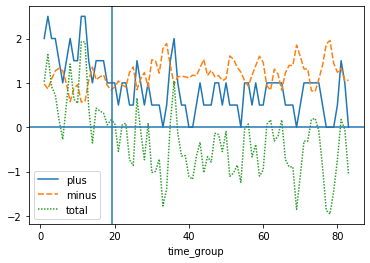

In [15]:
sns.lineplot(data=aggregates.loc[2].rolling(2).mean())
plt.axvline(x=19.3)
plt.axhline(y=0)

In [16]:
5 in broken_bikes.bike_id.values

False

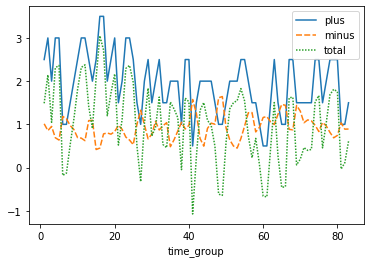

In [26]:
sns.lineplot(data=aggregates.loc[5].rolling(2).mean())

In [18]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression

In [20]:
translated_broken_bikes = broken_bikes.copy()
translated_broken_bikes.timestamp = \
    translated_broken_bikes.timestamp.apply(lambda x: map_timestamp(x, aggregate_time))
translated_broken_bikes.head()

,timestamp,bike_id
0,0,58
1,0,96
2,0,15
3,1,99
4,1,38


In [21]:
bikes_checking = bikes_scoring.BikesChecking(translated_broken_bikes, scores.bike_id.unique())
bikes_checking.bikes_states(99).head()

65    True
67    True
35    True
39    True
75    True
Name: valid, dtype: bool

In [22]:
temp = aggregates.groupby(["time_group", "bike_id"]).sum()
temp["is_valid"] = True
time_table = list({t[1] for t in aggregates.index})

tqdm.pandas("validation of bikes")

for t in tqdm(time_table):
    states = bikes_checking.bikes_states(t)
    time_df = temp.loc[t]
    
    intersection = set(time_df.index.values) & set(states.index.values)
    
    temp.loc[t].loc[intersection, "is_valid"] = states.loc[intersection]

  0%|                                                   | 0/84 [00:00<?, ?it/s]c:\users\wojciech\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
100%|█████████████████████████████████████████| 84/84 [00:00<00:00, 119.46it/s]


In [23]:
temp.loc[~temp.loc[:, "is_valid"]].tail(5)

plus     minus     total  is_valid
time_group bike_id                                    
83         58          1  1.051190 -0.051190     False
           77          1  1.120188 -0.120188     False
           83          1  1.253943 -0.253943     False
           96          1  1.886147 -0.886147     False
           99          0  1.080109 -1.080109     False

In [24]:
map_timestamp(time, 8)

21

In [25]:
for t in time_table:
    # lof score for each day
    # predict using LogisticRegression
    pass